In [1]:
from comet_ml import API
import pandas as pd
import os
import sys
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss, average_precision_score

current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'scripts'))

from Plots import Centiles_plot, ROC_plot, cumulative_centiles_plot, calibrate_display
from feature_engineering import preprocessing

test_data1 = pd.read_csv('../data/derivatives/test_data_saison_eli.csv')
test_data2 = pd.read_csv('../data/derivatives/test_data_saison_reg.csv')


COMET INFO: Downloading registry model 'xgboost', version '1.4.0', stage None from workspace 'me-pic'...
COMET INFO: Unzipping model to 'c:\\Users\\lebou\\Desktop\\Cours_Canada\\Data_science_IFT6758\\project_nhl_data\\ift6758-A08\\model\\xgboost' ...
COMET INFO: done!
c:\Users\lebou\Desktop\Cours_Canada\Data_science_IFT6758\project_nhl_data\ift6758-venv\lib\site-packages\xgboost\core.py:160: UserWarning: [18:19:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, User

Métrique AUC : {'xgboost': 0.8130643993456665, 'logistic_reg_angle': 0.5013603679418949, 'logistic_reg_dist-angle': 0.5476289828849552, 'logistic_reg_distance': 0.5475951842737645, 'boosted_logistic_reg': 0.7908396575820075}


<Figure size 1800x1200 with 0 Axes>

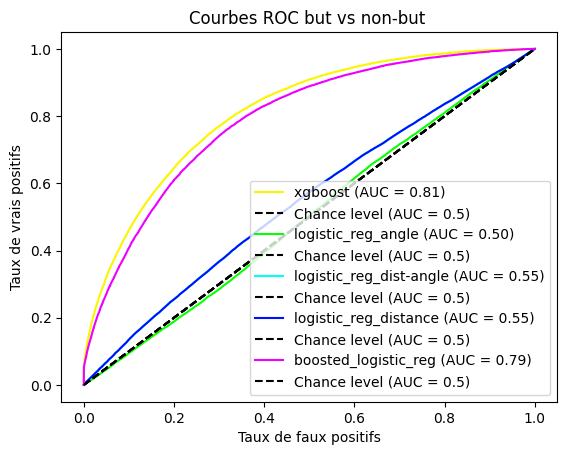

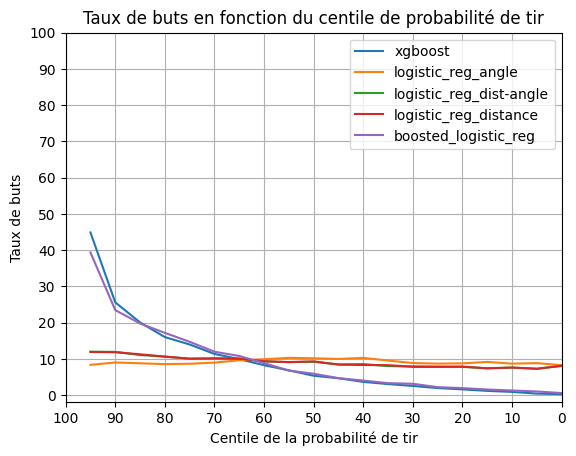

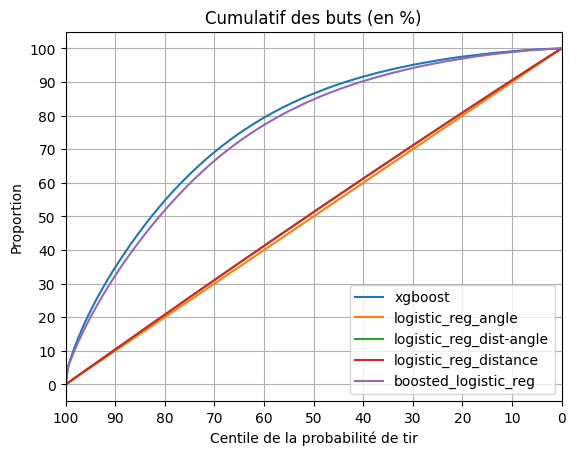

c:\Users\lebou\Desktop\Cours_Canada\Data_science_IFT6758\project_nhl_data\ift6758-venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\lebou\Desktop\Cours_Canada\Data_science_IFT6758\project_nhl_data\ift6758-venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


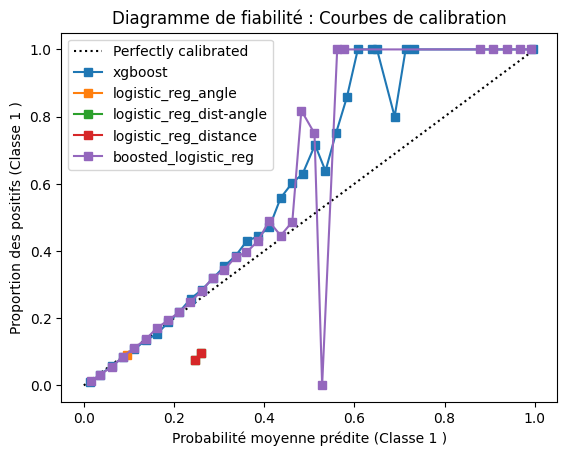

COMET INFO: Downloading registry model 'xgboost', version '1.4.0', stage None from workspace 'me-pic'...
COMET INFO: Unzipping model to 'c:\\Users\\lebou\\Desktop\\Cours_Canada\\Data_science_IFT6758\\project_nhl_data\\ift6758-A08\\model\\xgboost' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'logistic_reg_angle', version '1.1.0', stage None from workspace 'me-pic'...
COMET INFO: Unzipping model to 'c:\\Users\\lebou\\Desktop\\Cours_Canada\\Data_science_IFT6758\\project_nhl_data\\ift6758-A08\\model\\logistic_reg_angle' ...
COMET INFO: done!
c:\Users\lebou\Desktop\Cours_Canada\Data_science_IFT6758\project_nhl_data\ift6758-venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
COMET INFO: Downloading registry model 'logistic_reg_dist-angle', version '1.1.0', stage None from workspace 'me-pic'...
COMET INFO: Unzipping model to 'c:\\Users\\lebou\\Desktop\\Cours_Canada\\Data_science_

Métrique AUC : {'xgboost': 0.8130643993456665, 'logistic_reg_angle': 0.5013603679418949, 'logistic_reg_dist-angle': 0.5476289828849552, 'logistic_reg_distance': 0.5475951842737645, 'boosted_logistic_reg': 0.7908396575820075}


<Figure size 1800x1200 with 0 Axes>

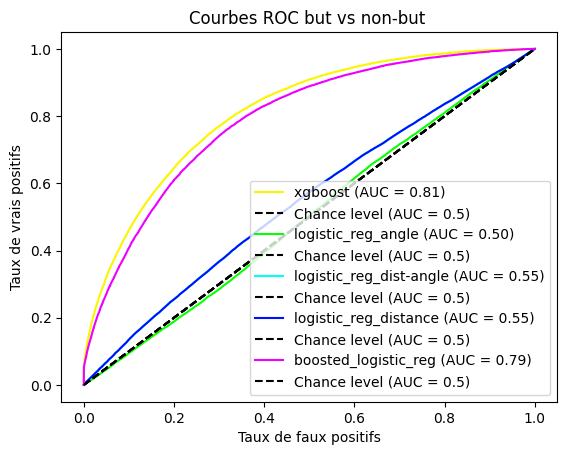

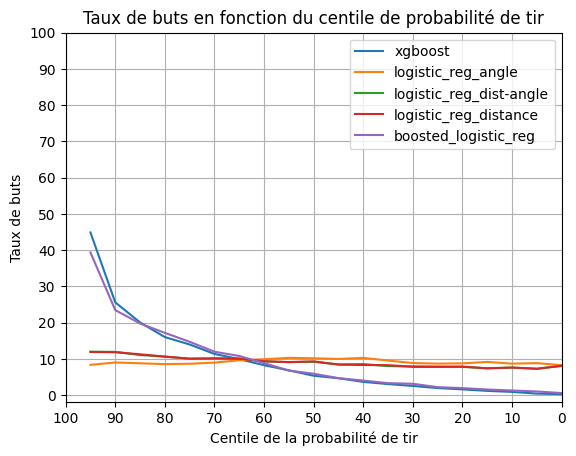

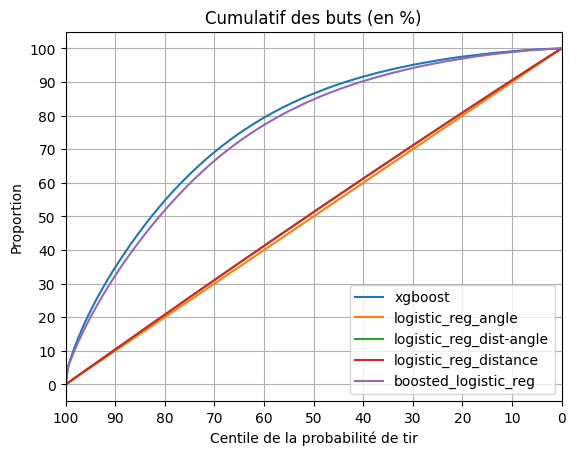

c:\Users\lebou\Desktop\Cours_Canada\Data_science_IFT6758\project_nhl_data\ift6758-venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\lebou\Desktop\Cours_Canada\Data_science_IFT6758\project_nhl_data\ift6758-venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


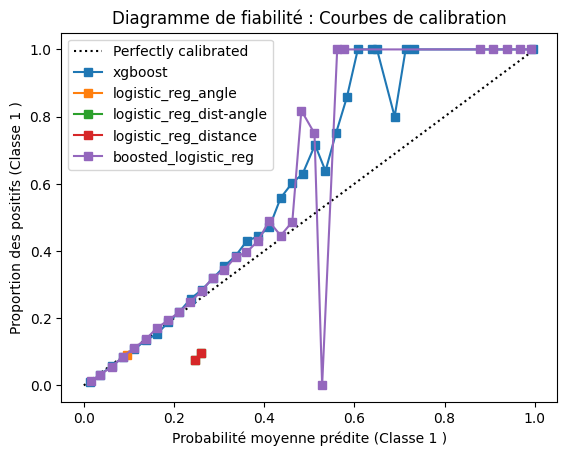

In [2]:
API_KEY = os.environ.get('COMET_API_KEY')
project_name = "milestone-2"
workspace = "me-pic"

api = API(api_key=API_KEY)

model_list = [    
    ("xgboost", "1.4.0", 'full'),  # 'full' signifie utiliser test_data1 et test_data2
    ("logistic_reg_angle", "1.1.0", 'angle'),  # 'logistic' signifie utiliser test_logistic
    ('logistic_reg_dist-angle', "1.1.0", 'dist-angle'),
    ('logistic_reg_distance', "1.1.0", 'distance'),
    ('boosted_logistic_reg', "1.0.0", 'full')
    ]

test_datasets = [('test_data1', test_data1), ('test_data2', test_data2)]


colors = sns.color_palette("hsv", len(model_list))
model_color_map = {model[0]: color for model, color in zip(model_list, colors)}

for dataset_name, dataset in test_datasets:
    CLFS = []
    Ys = []

    for idx, (model_name, model_version, data_type) in enumerate(model_list):
        try:
            output_path = f"../model/{model_name}"
            api.download_registry_model(workspace, model_name, model_version, output_path=output_path, expand=True)
            file_name = os.listdir(f'../model/{model_name}')
            
            with open(os.path.join(output_path, file_name[0]), 'rb') as file:
                model = pickle.load(file)
            
            if data_type == 'full':
                X, y = preprocessing(dataset, 'is_goal')
            elif data_type == 'angle':
                X, y = preprocessing(dataset, 'is_goal')
                X = X[['shot_angle']]
            elif data_type == 'distance':
                X, y = preprocessing(dataset, 'is_goal')
                X = X[['shot_distance']]
            elif data_type == 'dist-angle':
                X, y = preprocessing(dataset, 'is_goal')
                X = X[['shot_distance', 'shot_angle']]
            
            predictions = model.predict_proba(X)
            
            color = colors[idx]
            CLFS.append([[model], X, model_name])
            Ys.append([model_name, predictions[:, 1], color, True])

        except Exception as e:
            print(f"An error occurred with {model_name}: {e}")

    plt.figure(figsize=(18, 12))
    y = pd.Series(y)

    ROC_plot(y, Ys)
    Centiles_plot(y, Ys)
    cumulative_centiles_plot(y, Ys)
    calibrate_display(CLFS, y, n_bin=40)

def calibrate_display(classifier, y_val, n_bin=50):
    fig, ax = plt.subplots()
    for model, X, name in classifier:
        if len(model) != 2:
            CalibrationDisplay.from_estimator(model[0], X, y_val, n_bins=n_bin, name=name, ax=ax)
        else:
            CalibrationDisplay.from_predictions(model[0], model[1], n_bins=n_bin, name=name, ax=ax)

    ax.set_xlabel("Probabilité moyenne prédite (Classe 1)")
    ax.set_ylabel("Proportion des positifs (Classe 1)")
    ax.set_title("Diagramme de fiabilité : Courbes de calibration")
    ax.legend()
    plt.show()